In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.insert(0, '..')

In [4]:

import glob
import math

import seaborn
import pandas
from matplotlib import pyplot as plt

from src.experiments.analyze import enrich_results, plot_size_improvement, name_strategies


In [5]:
def read_parquet(pattern, **kwargs):
    frames = []
    for file in glob.glob(pattern):
        part = pandas.read_parquet(file, **kwargs)
        frames.append(part)

    df = pandas.concat(frames)
    return df
    

In [24]:
#ref = read_parquet('../output/results/trees_min_samples_leaf_2/*sklearn*')
#ref['min_samples_leaf'] = 1
#ref['trees'] = 100
#ref = ref[ref.split <5 ]

hyper = read_parquet('../output/results/depth_limiters/*.part')
#hyper = read_parquet('../output/results/max_depth/*trees*')
hyper['trees'] = hyper.n_estimators
#data = hyper
data = pandas.concat([hyper], ignore_index=True)
data = enrich_results(data, leaf_node_bytes_default=4)
#data['total_size_kb'] = data.total_size / 1000
data['leaf_size_percent'] = 100.0 * (data['leaf_size'] / data['total_size'])
data['unique_leaves_percent'] = 100.0 * (data['test_uniqueleaves'] / data['test_leaves'])
data = data[~data.dataset.isin(['1510'])]

for col in ['min_impurity_decrease', 'min_samples_split', 'max_leaf_nodes']:
    has_values = data[col].notna()
    data.loc[has_values, 'depth_limiter'] = col
    data.loc[has_values, 'depth_limiter_value'] = data.loc[has_values, col]

data.head(5)

,leaves_per_class,leaf_bits,split,test_nodes,test_leaves,test_leafsize,test_uniqueleaves,test_roc_auc,train_roc_auc,dataset,...,min_impurity_decrease,min_samples_split,trees,leaf_size,decision_size,total_size,leaf_size_percent,unique_leaves_percent,depth_limiter,depth_limiter_value
id,,,,,,,,,,,,,,,,,,,,,
f6dfaaa0-d7b1-4df7-a654-b92d5c3ad02c,NaN,NaN,0,458,234,2.0,2,84.285714,0.99986,40994,...,NaN,NaN,10,16.0,1792,1808.0,0.884956,0.854701,max_leaf_nodes,32.0
28b82a03-4a85-4185-8d4c-fdf3618a8226,1.0,NaN,0,458,234,2.0,2,84.285714,0.99986,40994,...,NaN,NaN,10,16.0,1792,1808.0,0.884956,0.854701,max_leaf_nodes,32.0
ca36780e-2ed7-41be-9766-be2d7f0fd80d,2.0,NaN,0,458,234,2.0,2,84.285714,0.99986,40994,...,NaN,NaN,10,16.0,1792,1808.0,0.884956,0.854701,max_leaf_nodes,32.0
b84c82bb-f8d1-490a-b133-429096e767f9,4.0,NaN,0,458,234,2.0,2,84.285714,0.99986,40994,...,NaN,NaN,10,16.0,1792,1808.0,0.884956,0.854701,max_leaf_nodes,32.0
98772f12-ab9e-4211-87aa-bd214f3d6017,8.0,NaN,0,458,234,2.0,2,84.285714,0.99986,40994,...,NaN,NaN,10,16.0,1792,1808.0,0.884956,0.854701,max_leaf_nodes,32.0


<Axes: xlabel='min_impurity_decrease', ylabel='unique_leaves_percent'>

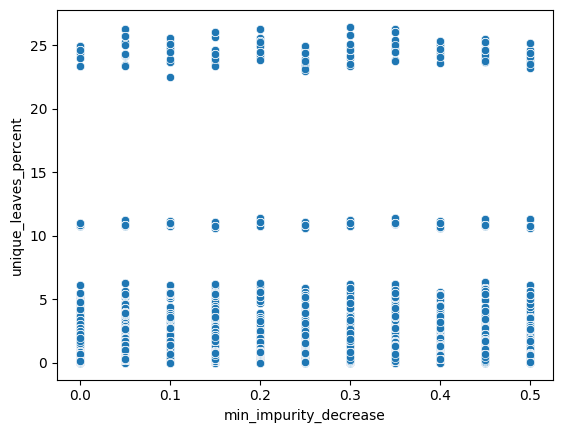

In [41]:
seaborn.scatterplot(data=data, y='unique_leaves_percent', x='min_impurity_decrease')

In [ ]:
seaborn.scatterplot(data=data, y='unique_leaves_percent', x='max_leaf_nodes')

<Axes: xlabel='min_samples_split', ylabel='unique_leaves_percent'>

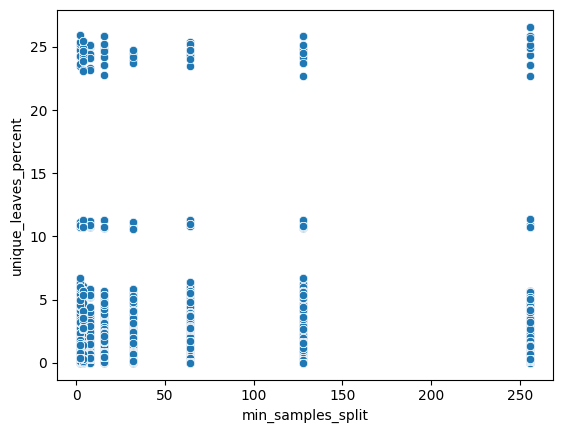

In [39]:
seaborn.scatterplot(data=data, y='unique_leaves_percent', x='min_samples_split')

In [25]:
data.depth_limiter.value_counts()

depth_limiter
min_impurity_decrease    98175
max_leaf_nodes           71400
min_samples_split        71400
Name: count, dtype: int64

In [37]:
sel.leaves_per_class.value_counts(dropna=False)

leaves_per_class
NaN    6885
Name: count, dtype: int64

In [36]:
sel.leaf_bits.value_counts(dropna=False)

leaf_bits
NaN    6885
Name: count, dtype: int64

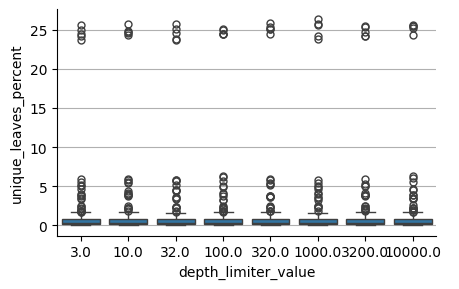

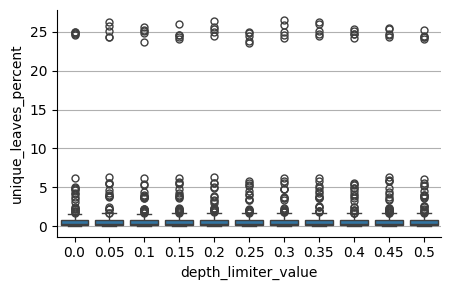

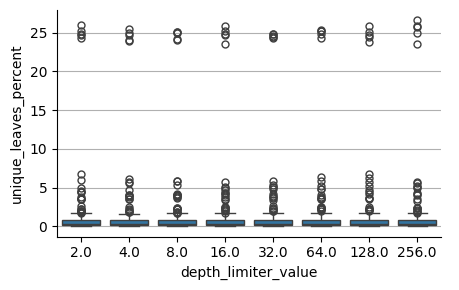

In [31]:
depth_limit = 'depth_limiter_value'
#depth_limit = 'max_depth'


def add_grid(g, **kwargs):
    for i, ax in enumerate(g.axes.flatten()):
        ax.grid(**kwargs)


sel = data.copy()
sel = name_strategies(sel)
sel = sel[(sel.strategy == 'original')]

#fig, axs = plt.subplots(ncols=2)
height = 3.0
aspect = 1.5

for strategy, df in sel.groupby('depth_limiter'):

    #print(df.head())
    
    g = seaborn.catplot(data=<,
                    x=depth_limit,
                    kind='box',
                    y='unique_leaves_percent',
                    #col='depth_limiter',
                    height=height, aspect=aspect)
    #g.set(ylim=(0, 105))
    add_grid(g, axis='y')
    g.figure.tight_layout()
    g.figure.savefig(f'leaf-uniqueness-{strategy}.png')




In [ ]:
g = seaborn.catplot(data=sel,
                x=depth_limit, kind='box', y='leaf_size_percent', 
                height=height, aspect=aspect,)
g.set(ylim=(0, 105))
add_grid(g, axis='y')
g.figure.tight_layout()
g.figure.savefig('leaf-proportion.png')
